# Evaluation

This notebook relies on a lot of different resources including the [Huggingface Documentation](https://huggingface.co/docs/transformers/index) and the official [tutorials](https://huggingface.co/docs/transformers/notebooks) for the library. Selective prediction and ECE implementations are adapted from https://github.com/gpleiss/temperature_scaling and https://github.com/timrudner/function-space-empirical-bayes


## Huggingface Model Loading and Finetuning

we start with a pretrained BERT model and fintune it on the RTE dataset from the GLUE benchmark. Let's first import the environment. 

In [1]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm.auto import tqdm
import evaluate
import numpy as np
from torch.nn import functional as F
from typing import Union
import matplotlib.pyplot as plt

2023-10-30 00:32:16.737719: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Load the RTE textual entailment dataset from the GLUE benchmark with BERT tokenizers. 

In [2]:
# Load the dataset
dataset = load_dataset("glue", "rte")

Found cached dataset glue (/home/yk2516/.cache/huggingface/datasets/glue/rte/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Define the custom tokenization function for preprocessing

In [4]:
def tokenize_function(example):
  tokenized_example = tokenizer(
      example["sentence1"],
      example["sentence2"],
      max_length=tokenizer.model_max_length,
      padding="max_length",
      truncation=True,
  )
  # Skip dummy label for test set
  if example["label"] != -1:
    tokenized_example["label"] = example["label"]
  return tokenized_example

In [5]:
tokenized_datasets = dataset.map(
    tokenize_function,
    remove_columns=["sentence1", "sentence2", "idx"]
)

Loading cached processed dataset at /home/yk2516/.cache/huggingface/datasets/glue/rte/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-38e1720e38190d8b.arrow
Loading cached processed dataset at /home/yk2516/.cache/huggingface/datasets/glue/rte/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-f4dbee7607f977f5.arrow
Loading cached processed dataset at /home/yk2516/.cache/huggingface/datasets/glue/rte/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-07be00955086e280.arrow


In [6]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 277
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
})

In [7]:
# # Prepare for training
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

# # For the purpose of this notebook we will use smaller datasets
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=42).select(range(200))

# # Let's first look at what example in our data looks like
print(small_train_dataset[0])

Loading cached shuffled indices for dataset at /home/yk2516/.cache/huggingface/datasets/glue/rte/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-eb48c8e3aa984e2d.arrow
Loading cached shuffled indices for dataset at /home/yk2516/.cache/huggingface/datasets/glue/rte/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-cc1f42b147b3eec7.arrow


{'labels': tensor(0), 'input_ids': tensor([  101,  5749,  1106,   170,  4265,  8214,  1113,  1103, 20728,  2597,
         1115,  1108,  2085,  1107,  2056,  1118,  1103,  5818,  1113,  1570,
         5820,  1107,  5135, 27290,  1174, 11763,  1104,  5469,   143,  3984,
         1605,  1105, 15527,   113,   140, 12150,  9919,   114,   117,  1103,
         2170, 15172,  1416,  1336,  1129,  1231, 27563,  1157, 14061,  1755,
        16137,   102,  1109,  8214,  1113, 20728,  2597,  1144,  1151,  3903,
         1107,  8547,  1103, 15172,  1121, 16137,   119,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [8]:
# Dataloader (this will give us an iterator with specified batch size)
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

Set up models and optimizers for the training loop

In [9]:
# Define model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

# Definfe optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Learning rate scheduler
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Check if there is GPU and move model to device accordingly
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"device={device}")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device=cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

start training

In [10]:
# # Main training loop
progress_bar = tqdm(range(num_training_steps))
model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)


  0%|          | 0/375 [00:00<?, ?it/s]

Let's do a standard accuracy evaluation

In [11]:
metric = evaluate.load("accuracy")
model.eval()

logits_list = []
labels_list = []

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits    
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

    # append
    logits_list.append(logits.detach().cpu())
    labels_list.append(batch["labels"].detach().cpu())

print("Accuracy: ", metric.compute())

Accuracy:  {'accuracy': 0.615}


Now we collect the logits and labels for ECE and selective prediction computation. 

In [12]:
final_logits = torch.concat(logits_list)
final_labels = torch.concat(labels_list)

## ECE

In [13]:
# adapted from https://github.com/gpleiss/temperature_scaling
class ECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).

    The input to this loss is the logits of a model, NOT the softmax scores.

    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:

    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |

    We then return a weighted average of the gaps, based on the number
    of samples in each bin

    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        self.bin_list = []
        self.avg_confidence_in_bin_list = []
        self.accuracy_in_bin_list = []

        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
            else:
                accuracy_in_bin = -100
                avg_confidence_in_bin = -100
            self.bin_list.append([bin_lower.item(),bin_upper.item()])
            self.avg_confidence_in_bin_list.append(avg_confidence_in_bin)
            self.accuracy_in_bin_list.append(accuracy_in_bin)            
        return ece



In [14]:
ece_loss = ECELoss()
print("ece_loss: ", ece_loss(final_logits,final_labels))

ece_loss:  tensor([0.2401])


In [15]:
print(f"confidence: {ece_loss.avg_confidence_in_bin_list}")
print(f"accuracy  : {ece_loss.accuracy_in_bin_list}")

confidence: [-100, -100, -100, -100, -100, -100, -100, tensor(0.5141), tensor(0.5768), tensor(0.6296), tensor(0.7038), tensor(0.7725), tensor(0.8424), tensor(0.8968), tensor(0.9689)]
accuracy  : [-100, -100, -100, -100, -100, -100, -100, tensor(0.3750), tensor(0.4444), tensor(0.4444), tensor(0.3750), tensor(0.7000), tensor(0.7073), tensor(0.7778), tensor(0.5977)]


In [16]:
confidence_arr = torch.tensor(list(map(lambda x: x if x >= 0 else 0, ece_loss.avg_confidence_in_bin_list)))
accuracy_arr = torch.tensor(list(map(lambda x: x if x >= 0 else 0, ece_loss.accuracy_in_bin_list)))

print(f"confidence: {confidence_arr}")
print(f"accuracy  : {accuracy_arr}")

confidence: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5141, 0.5768,
        0.6296, 0.7038, 0.7725, 0.8424, 0.8968, 0.9689])
accuracy  : tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3750, 0.4444,
        0.4444, 0.3750, 0.7000, 0.7073, 0.7778, 0.5977])


In [17]:
bins_interval = np.array(ece_loss.bin_list)
bins = bins_interval.mean(axis=-1)

In [18]:
bins

array([0.03333334, 0.10000001, 0.16666668, 0.23333335, 0.30000001,
       0.36666669, 0.43333337, 0.5       , 0.56666663, 0.6333333 ,
       0.69999999, 0.76666668, 0.83333334, 0.90000001, 0.96666667])

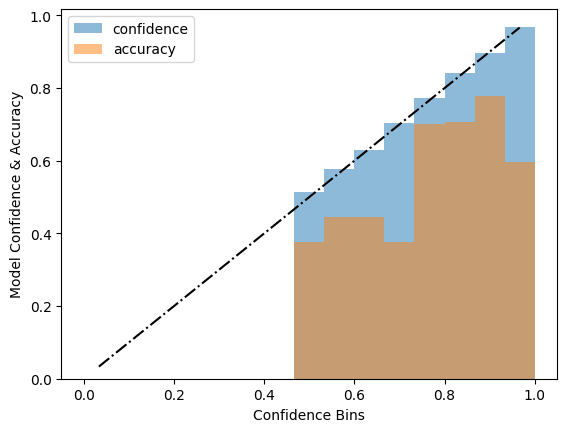

In [19]:
plt.figure()
plt.bar(bins, np.array(confidence_arr), width=np.mean(bins_interval[:,1]-bins_interval[:,0]), alpha=0.5, label='confidence')
plt.bar(bins, np.array(accuracy_arr), width=np.mean(bins_interval[:,1]-bins_interval[:,0]), alpha=0.5, label='accuracy')
plt.plot(bins, bins, '-.',color='black')
plt.xlabel("Confidence Bins")
plt.ylabel("Model Confidence & Accuracy")
plt.legend()
plt.show()

## Selective Prediction

In [20]:
# adapted from https://github.com/timrudner/function-space-empirical-bayes
def selective_accuracy(p, Y, confidence_arr):
    '''Selective Prediction Accuracy
    Uses predictive entropy with T thresholds.
    Arguments:
        p: (B, d)

    Returns:
        (B,)
    '''
    
    p = F.softmax(p, dim=-1)
    thresholds = torch.cat([torch.tensor([0.001]), torch.linspace(0.01, 1, 100)], dim=0)
    predictions_test = p.argmax(-1)
    accuracies_test = predictions_test == Y

    thresholded_accuracies = []
    for threshold in thresholds:
        mask = (confidence_arr>=threshold)
        if torch.sum(mask) == 0:
            thresholded_acc = 1
        else:
            thresholded_acc = torch.mean(accuracies_test[mask].float())
        thresholded_accuracies.append(thresholded_acc)
    values_id = torch.tensor(thresholded_accuracies)    
    return thresholds, values_id


In [21]:
scores_id = torch.max(F.softmax(final_logits, dim=1),1)[0]

In [22]:
sel_acc_thresholds, sel_acc_per_thresholds = selective_accuracy(final_logits, final_labels, scores_id)

In [23]:
print(f"sel_acc_thresholds.shape={sel_acc_thresholds.shape}")
print(f"sel_acc_per_thresholds.shape={sel_acc_per_thresholds.shape}")

sel_acc_thresholds.shape=torch.Size([101])
sel_acc_per_thresholds.shape=torch.Size([101])


In [24]:
sel_acc_thresholds

tensor([0.0010, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
        0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
        0.2700, 0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500,
        0.3600, 0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400,
        0.4500, 0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300,
        0.5400, 0.5500, 0.5600, 0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200,
        0.6300, 0.6400, 0.6500, 0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100,
        0.7200, 0.7300, 0.7400, 0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000,
        0.8100, 0.8200, 0.8300, 0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900,
        0.9000, 0.9100, 0.9200, 0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800,
        0.9900, 1.0000])

In [25]:
sel_acc_per_thresholds

tensor([0.6150, 0.6150, 0.6150, 0.6150, 0.6150, 0.6150, 0.6150, 0.6150, 0.6150,
        0.6150, 0.6150, 0.6150, 0.6150, 0.6150, 0.6150, 0.6150, 0.6150, 0.6150,
        0.6150, 0.6150, 0.6150, 0.6150, 0.6150, 0.6150, 0.6150, 0.6150, 0.6150,
        0.6150, 0.6150, 0.6150, 0.6150, 0.6150, 0.6150, 0.6150, 0.6150, 0.6150,
        0.6150, 0.6150, 0.6150, 0.6150, 0.6150, 0.6150, 0.6150, 0.6150, 0.6150,
        0.6150, 0.6150, 0.6150, 0.6150, 0.6150, 0.6150, 0.6173, 0.6205, 0.6250,
        0.6283, 0.6263, 0.6263, 0.6263, 0.6223, 0.6290, 0.6339, 0.6374, 0.6409,
        0.6461, 0.6457, 0.6457, 0.6437, 0.6437, 0.6512, 0.6512, 0.6471, 0.6450,
        0.6450, 0.6566, 0.6545, 0.6503, 0.6500, 0.6541, 0.6536, 0.6600, 0.6507,
        0.6458, 0.6454, 0.6423, 0.6391, 0.6230, 0.6330, 0.6250, 0.6082, 0.6042,
        0.6042, 0.6000, 0.6044, 0.5977, 0.5802, 0.6000, 0.7049, 0.6809, 0.6786,
        1.0000, 1.0000])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


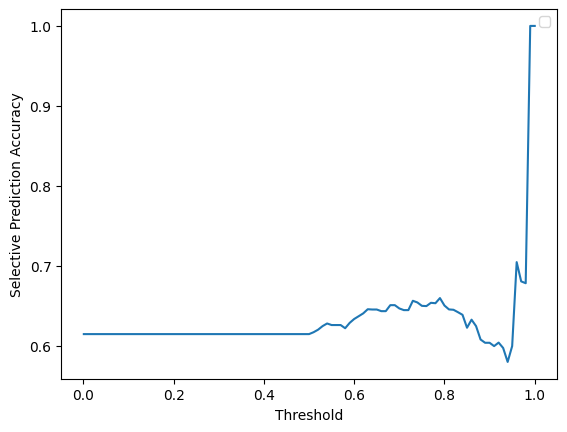

In [26]:
plt.figure()
plt.plot(sel_acc_thresholds, sel_acc_per_thresholds)
plt.xlabel("Threshold")
plt.ylabel("Selective Prediction Accuracy")
plt.legend()
plt.show()

## selective coverage-accuracy area (SCAA)

In [27]:
import scipy

In [28]:
scipy.integrate.trapezoid(sel_acc_per_thresholds,sel_acc_thresholds)

0.6304051